In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from sdm_ml.gp.multi_output_gp import MultiOutputGP
from autograd_gp.gpflow.helpers import compute_latent_predictions
from os.path import join
from glob import glob
import os
import numpy as np

/anaconda2/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda2/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda2/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda2/envs/tf1/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: 

Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [3]:
base_dir = '../../experiments/experiment_summaries/to_summarise/bbs/mogp_cv_one_se/trained_model/'
names = np.load(join(base_dir, '..', 'names.npy'), allow_pickle=True)

glob(join(base_dir, '*'))

['../../experiments/experiment_summaries/to_summarise/bbs/mogp_cv_one_se/trained_model/saved_model',
 '../../experiments/experiment_summaries/to_summarise/bbs/mogp_cv_one_se/trained_model/model_results.pkl',
 '../../experiments/experiment_summaries/to_summarise/bbs/mogp_cv_one_se/trained_model/data.pkl',
 '../../experiments/experiment_summaries/to_summarise/bbs/mogp_cv_one_se/trained_model/parameters.pkl']

In [4]:
mogp = MultiOutputGP.restore_from_file_new_style(join(base_dir, 'saved_model'), join(base_dir, 'data.pkl'))


/anaconda2/envs/tf1/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
/anaconda2/envs/tf1/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.0 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
mogp.m

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/feature/feat/Z,Parameter,None,(none),True,"(100, 8)",True,"[[-1.7140577104654258, -0.4004851170814922, -1..."
SVGP/kern/W,Parameter,"N(0.0,0.26833333333333337)",(none),True,"(371, 10)",True,"[[0.48019098499176405, 0.0561115507994512, 0.5..."
SquaredExponential/lengthscales,Parameter,"Ga(3.0,3.0)",+ve,True,"(8,)",True,"[13.943684461184146, 4.113082763643068, 1.0949..."
SquaredExponential/variance,Parameter,None,+ve,False,(),True,0.1
SquaredExponential/lengthscales,Parameter,"Ga(3.0,3.0)",+ve,True,"(8,)",True,"[12.851877276740458, 1.051544285881389, 12.201..."
SquaredExponential/variance,Parameter,None,+ve,False,(),True,0.1
SquaredExponential/lengthscales,Parameter,"Ga(3.0,3.0)",+ve,True,"(8,)",True,"[3.5180440875962122, 13.79307468626681, 2.2717..."
SquaredExponential/variance,Parameter,None,+ve,False,(),True,0.1
SquaredExponential/lengthscales,Parameter,"Ga(3.0,3.0)",+ve,True,"(8,)",True,"[11.115001844342395, 1.61147867156616, 0.78052..."
SquaredExponential/variance,Parameter,None,+ve,False,(),True,0.1


In [6]:
from sdm_ml.dataset import BBSDataset

In [7]:
dataset = BBSDataset.init_using_env_variable()

In [8]:
test_set = dataset.test_set

In [9]:
covariates = test_set.covariates

In [10]:
scaled_test_cov = mogp.scaler.transform(covariates.values)
scaled_train_cov = mogp.scaler.transform(dataset.training_set.covariates.values)

In [11]:
import numpy as np

combined_cov = np.concatenate([scaled_train_cov, scaled_test_cov])

In [12]:
latent_mean, latent_cov = compute_latent_predictions(mogp.m, combined_cov, mix_latents=False)

(array([ 55., 192., 322., 402., 527., 373., 212., 206., 209., 271.]),
 array([-1.98473647, -1.51229322, -1.03984997, -0.56740672, -0.09496347,
         0.37747978,  0.84992303,  1.32236628,  1.79480952,  2.26725277,
         2.73969602]),
 <a list of 10 Patch objects>)

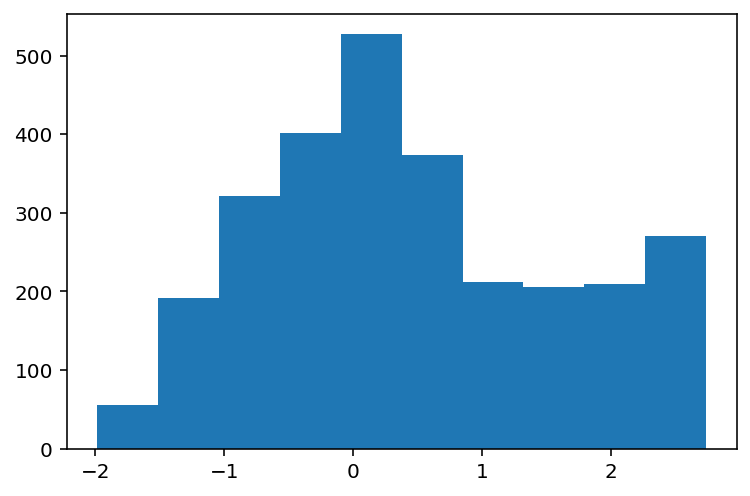

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(latent_mean[:, 8])

In [14]:
W = mogp.m.as_pandas_table().loc['SVGP/kern/W']
W = W.value

In [15]:
W.shape

(371, 10)

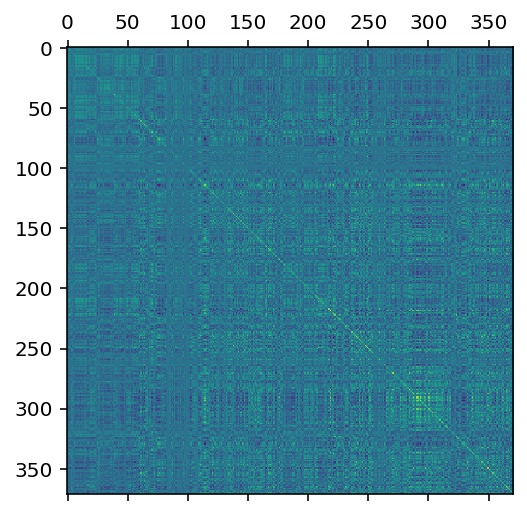

In [16]:
from ml_tools.normals import covar_to_corr
import pandas as pd

# Is this the covariance matrix between species?
# I think it might be, since all the kernel components have the same variance.
plt.matshow(0.1 * 9 * W[:, :9] @ W[:, :9].T + np.outer(W[:, 9], W[:, 9]) * (0.4 / 0.268))

In [17]:
cov_mat = 0.1 * 9 * W[:, :9] @ W[:, :9].T + np.outer(W[:, 9], W[:, 9]) * (0.4 / 0.268)

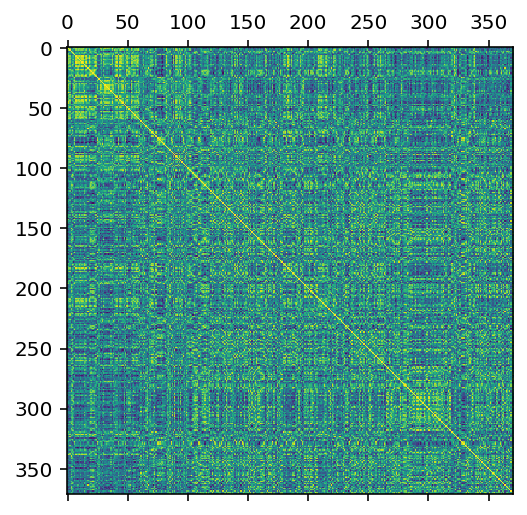

In [18]:
plt.matshow(covar_to_corr(cov_mat))

In [19]:
species_corr_df = pd.DataFrame(covar_to_corr(cov_mat), columns=dataset.training_set.outcomes.columns,
                               index=dataset.training_set.outcomes.columns)

In [20]:
species_corr_df['Golden-winged Warbler'].sort_values().tail(20)

Black-billed Cuckoo         0.691004
Blue Jay                    0.694671
Eastern Phoebe              0.698323
Hooded Merganser            0.701395
Scarlet Tanager             0.716554
Wild Turkey                 0.717205
Connecticut Warbler         0.732316
Yellow-bellied Sapsucker    0.733102
Red-eyed Vireo              0.735097
Eastern Wood-Pewee          0.738570
American Crow               0.748052
Ovenbird                    0.750370
Eastern Whip-poor-will      0.756835
Henslow's Sparrow           0.769434
Rose-breasted Grosbeak      0.772572
Chipping Sparrow            0.773783
White-breasted Nuthatch     0.801726
Veery                       0.826724
Blue-winged Warbler         0.833744
Golden-winged Warbler       1.000000
Name: Golden-winged Warbler, dtype: float64

In [21]:
bird_1_name = 'Ovenbird'
bird_2_name = "Eastern Whip-poor-will"
bird_3_name = 'Red-headed Woodpecker'

bird_1_id = np.argmax(names == bird_1_name)
bird_2_id = np.argmax(names == bird_2_name)
bird_3_id = np.argmax(names == bird_3_name)

bird_1_id, bird_2_id, bird_3_id

(306, 125, 119)

In [22]:
train_presences = dataset.training_set.outcomes.sum()

corr_with_presences = pd.concat([species_corr_df['Black-and-white Warbler'], train_presences], axis=1, keys=['Correlation', 'Presences'])

corr_with_presences.sort_values(by='Correlation').tail(20)



,Correlation,Presences
Louisiana Waterthrush,0.730443,109
Scarlet Tanager,0.731588,382
Eastern Whip-poor-will,0.746043,43
Belted Kingfisher,0.751453,239
Least Flycatcher,0.763364,355
Winter Wren,0.765308,163
Northern Parula,0.812980,366
Blue-headed Vireo,0.827808,222
Black-throated Blue Warbler,0.832667,117
Ovenbird,0.834859,504


In [23]:
corr_array = species_corr_df.values

triu_part = np.triu(corr_array, 1)
triu_part[np.diag_indices_from(triu_part)] = -99

max_indices = np.argmax(triu_part, axis=1)
max_corr = triu_part[np.arange(triu_part.shape[0]), max_indices]
prevalences = train_presences[species_corr_df.index.values]

correlations = pd.DataFrame({'max_corr': max_corr, 'prevalence': prevalences, 'species1': species_corr_df.index.values,
                             'species2': species_corr_df.index.values[max_indices], 
                             'species2_prevalence': prevalences.loc[species_corr_df.index.values[max_indices]].values})

correlations[(correlations['prevalence'] < 50) & (correlations['species2_prevalence'] > 100)].sort_values('max_corr', ascending=False)

,max_corr,prevalence,species1,species2,species2_prevalence
Canvasback,0.926184,43,Canvasback,American Coot,104
Gray Partridge,0.894427,23,Gray Partridge,Northern Harrier,168
Swainson's Warbler,0.891693,20,Swainson's Warbler,Hooded Warbler,234
Golden Eagle,0.887370,49,Golden Eagle,Brewer's Sparrow,134
American Three-toed Woodpecker,0.870766,12,American Three-toed Woodpecker,Lincoln's Sparrow,205
Bufflehead,0.852675,25,Bufflehead,Wilson's Snipe,328
Pine Grosbeak,0.851739,38,Pine Grosbeak,Lincoln's Sparrow,205
Rusty Blackbird,0.849611,13,Rusty Blackbird,Northern Waterthrush,194
Rufous-crowned Sparrow,0.841214,22,Rufous-crowned Sparrow,Bewick's Wren,137
Yellow-crowned Night-Heron,0.838899,12,Yellow-crowned Night-Heron,Fish Crow,178


In [24]:
triu_part

array([[-9.90000000e+01,  4.99265784e-01,  2.09729152e-01, ...,
         2.77954969e-01, -3.97995883e-01, -4.86613185e-01],
       [ 0.00000000e+00, -9.90000000e+01,  6.39667089e-01, ...,
        -1.46720366e-01, -4.25332309e-01, -1.28766628e-01],
       [ 0.00000000e+00,  0.00000000e+00, -9.90000000e+01, ...,
         2.77163589e-02,  1.11503219e-02,  5.08564576e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.90000000e+01,  1.74232462e-01, -2.92785983e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -9.90000000e+01,  5.78433499e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00, -9.90000000e+01]])

In [25]:
import pandas as pd

test_lat_lon = dataset.test_set.lat_lon
train_lat_lon = dataset.training_set.lat_lon
combined_lat_lon = pd.concat([train_lat_lon, test_lat_lon])

In [26]:
dataset.training_set.covariates.head()

,bio2,bio3,bio5,bio8,bio9,bio15,bio16,bio18
2,134.0,33.0,257.0,141.0,-67.0,65.0,166.0,152.0
3,137.0,34.0,251.0,136.0,-3.0,46.0,176.0,167.0
10,112.0,31.0,169.0,80.0,-70.0,21.0,211.0,211.0
14,124.0,32.0,191.0,99.0,-54.0,42.0,244.0,244.0
20,130.0,33.0,208.0,122.0,-34.0,51.0,237.0,237.0


In [27]:
x_plot = np.linspace(-3, 3, 100)
y_plot = np.linspace(-3, 3, 100)

grid_x, grid_y = np.meshgrid(x_plot, y_plot)

In [28]:
to_pred_x = grid_x.reshape(-1)
to_pred_y = grid_y.reshape(-1)

In [29]:
to_predict = np.zeros((len(to_pred_x), dataset.training_set.covariates.shape[1]))
to_predict[:, 1] = to_pred_x
to_predict[:, 5] = to_pred_y

latent_mean, latent_cov = compute_latent_predictions(
    mogp.m, to_predict, mix_latents=True, full_output_cov_if_mix=False)

In [30]:
test_set.covariates.columns[[1, 5]]

Index(['bio3', 'bio15'], dtype='object')

In [31]:
from scipy.stats import norm

In [32]:
reshaped = latent_mean.reshape(100, 100, -1)

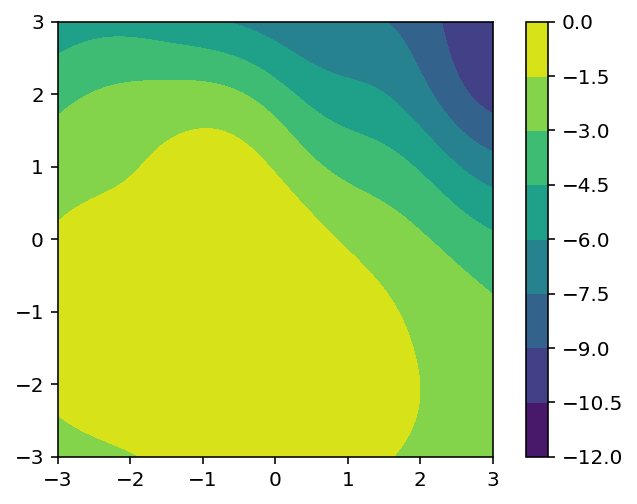

In [33]:
plt.contourf(grid_x, grid_y, norm.logcdf(reshaped[..., bird_1_id]))
plt.axis('square')
plt.colorbar()

In [34]:
from ml_tools.utils import load_pickle_safely

In [35]:
# Load Random Forest

In [36]:
rf = load_pickle_safely('./function_comparison/rf_models.pkl')

/anaconda2/envs/tf1/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.0 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda2/envs/tf1/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.0 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda2/envs/tf1/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.0 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [37]:
from sdm_ml.gp.utils import load_saved_gpflow_model
# Functions relying on closures to get the partial plots

log_regs = load_pickle_safely('./function_comparison/log_reg_models.pkl')

def get_rf_partial(species_id, clip=True):

    cur_forest = rf[species_id]
    rf_pred = cur_forest.predict_log_proba(to_predict)
    rf_reshaped = rf_pred.reshape(100, 100, -1)[..., 1]
    rf_reshaped = np.maximum(-15 * np.log(10), rf_reshaped)
    
    return rf_reshaped


def get_sogp_partial(species_id):
    
    sogp = load_saved_gpflow_model(f'./function_comparison/sogp/model_species_{species_id}')
    
    sogp_pred = sogp.predict_y(to_predict)[0]
    
    sogp_reshaped = np.log(sogp_pred.reshape(100, 100))
    
    return sogp_reshaped


def get_log_reg_partial(species_id):
    
    relevant = log_regs[species_id]
    log_probs_log_reg = relevant.predict_log_proba(to_predict)[..., 1]
    log_reg_reshaped = log_probs_log_reg.reshape(100, 100)
    
    return log_reg_reshaped


def get_mogp_partial(species_id):
    
    return reshaped[..., species_id]

/anaconda2/envs/tf1/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [38]:
train_outcomes = dataset.training_set.outcomes

In [39]:
# Find AUC
from sdm_ml.evaluation import load_all_dataset_sdm_model_results
from ml_tools.evaluation import auc_with_nan, multi_class_eval, neg_log_loss_with_labels

results = load_all_dataset_sdm_model_results('../../experiments/experiment_summaries/to_summarise/')

In [40]:
lr_y_p, y_t = results['bbs']['log_reg_unreg']
rf_y_p, _ = results['bbs']['rf_cv']
sogp_y_p, _ = results['bbs']['sogp_bias']
mogp_y_p, _ = results['bbs']['mogp_cv_one_se']

all_aucs = {model_name: multi_class_eval(model_y_p, y_t, auc_with_nan, 'auc') for model_name, model_y_p in zip(
    ['LR', 'RF', 'SOGP', 'MOGP'], [lr_y_p, rf_y_p, sogp_y_p, mogp_y_p])}

all_neg_log_loss = {model_name: multi_class_eval(model_y_p, y_t, neg_log_loss_with_labels, 'log_lik') for model_name, model_y_p in zip(
    ['LR', 'RF', 'SOGP', 'MOGP'], [lr_y_p, rf_y_p, sogp_y_p, mogp_y_p])}

In [41]:
all_aucs['LR'].iloc[bird_1_id], all_aucs['LR']['Ovenbird']

(0.8656857717644275, 0.8656857717644275)

/anaconda2/envs/tf1/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/anaconda2/envs/tf1/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/anaconda2/envs/tf1/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


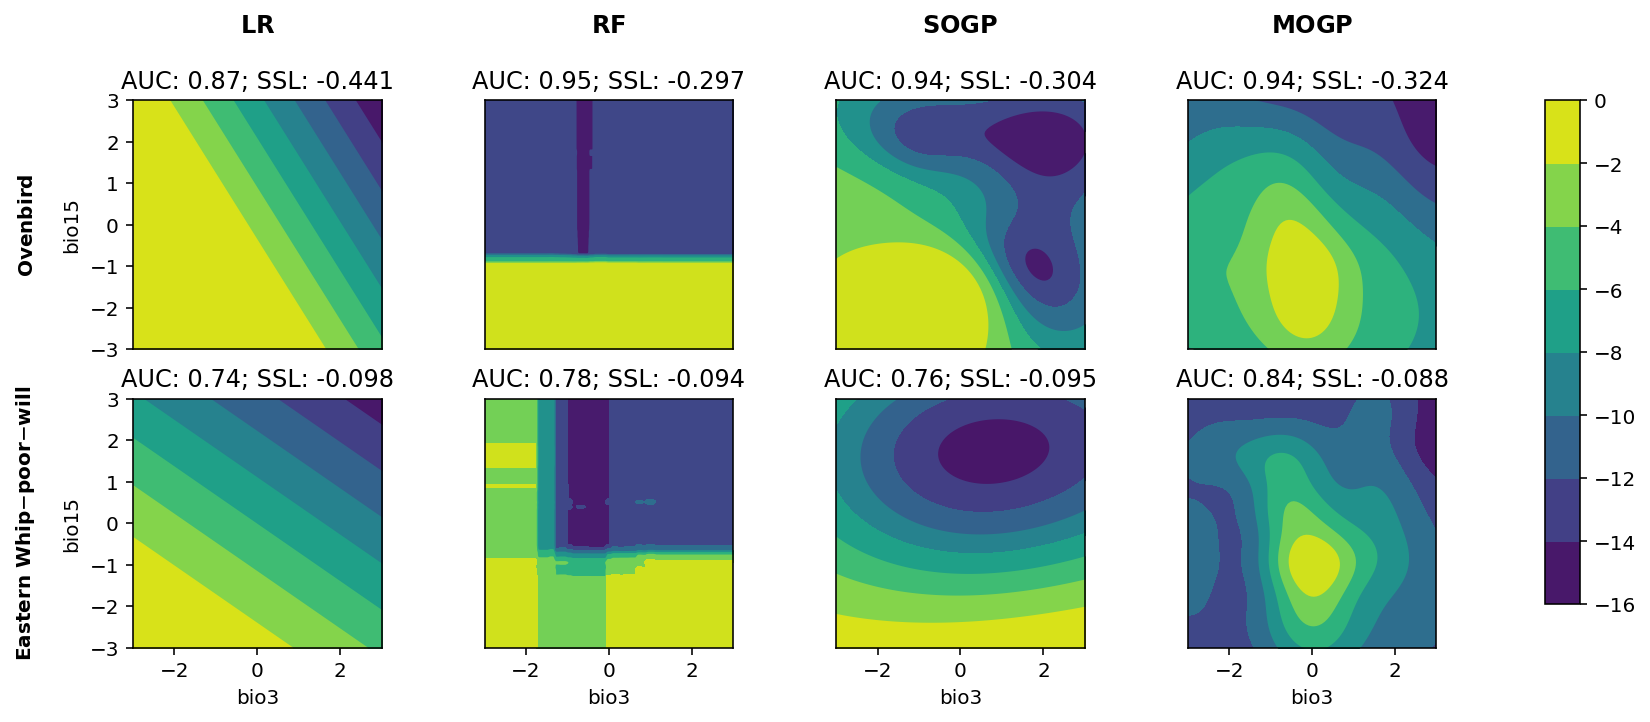

In [71]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


f, all_ax = plt.subplots(2, 4, constrained_layout=True)

vmin = -5

cbarticks = np.arange(vmin, 0., 0.5).tolist() + [0.]

cur_x_covs = scaled_train_cov[:, 1]
cur_y_covs = scaled_train_cov[:, 5]

ims = list()

for i, (cur_species, ax) in enumerate(zip([bird_1_id, bird_2_id, bird_3_id], all_ax)):
    
    for cur_partial_fn, cur_ax, cur_model_name in zip([get_log_reg_partial, get_rf_partial, get_sogp_partial, 
                                                       get_mogp_partial], ax, ['LR', 'RF', 'SOGP', 'MOGP']):
        
        cur_partial_plot = cur_partial_fn(cur_species)
        
        cur_im = cur_ax.contourf(grid_x, grid_y, cur_partial_plot - cur_partial_plot.max())
        
        cur_present = train_outcomes.iloc[:, cur_species].values
        
        #cur_ax.scatter(cur_x_covs[cur_present == 1], cur_y_covs[cur_present == 1], color='g', alpha=0.1)
        #cur_ax.scatter(cur_x_covs[cur_present == 0], cur_y_covs[cur_present == 0], color='r', alpha=0.01)  
        
        cur_auc = all_aucs[cur_model_name][names[cur_species]]
        cur_log_lik = all_neg_log_loss[cur_model_name][names[cur_species]]
        
        cur_title = f"AUC: {cur_auc:.2f}; SSL: {cur_log_lik:.3f}"
        
        if i == 0:
            
            cur_title = r'$\bf{' + cur_model_name + "}$" + '\n\n' + cur_title
        
        cur_ax.set_title(cur_title)
        
        ims.append(cur_im)
    
    for cnt in ims:
        for c in cnt.collections:
            c.set_edgecolor("face")
    
    if i == 0:
        im_cbar = ims[0]
    
    for ax in ax:
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        
#for cur_ax, cur_title in zip(all_ax[0, :], ['LR\nbla', 'RF', 'SOGP', 'MOGP']):
#    cur_ax.set_title(cur_title)

for cur_ax in all_ax.reshape(-1):
    cur_ax.axis('square')
    
for cur_ax, cur_species in zip(all_ax[:, 0], [names[bird_1_id], names[bird_2_id], names[bird_3_id]]):
    cur_ax.set_ylabel(r'$\bf{' + cur_species.replace(' ', '\ ').replace('-', '\mathrm{-}') + '}$\n\nbio15')
    cur_ax.get_yaxis().set_visible(True)
    
for cur_ax in all_ax[-1, :]:
    cur_ax.set_xlabel('bio3')
    cur_ax.get_xaxis().set_visible(True)
    
f.subplots_adjust(left=0.07, top=0.85, bottom=0.09, right=0.85)
cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
f.colorbar(im_cbar, cax=cbar_ax)

#divider = make_axes_locatable(ax[3])
#cax = divider.append_axes("right", size="5%", pad=0.05)
#plt.colorbar(im, cax=cax)

#plt.colorbar()

f.set_size_inches(12, 5)
#f.tight_layout()

plt.savefig('/Users/ingramm/Projects/uni_melb/papers/mogp/partial_plot_comparison_multiple.pdf')
#plt.savefig('/Users/ingramm/Projects/uni_melb/papers/mogp/partial_plot_comparison_multiple.png', dpi=300)

In [43]:
# Check how significant the difference is
from sdm_ml.evaluation import load_all_dataset_sdm_model_results

In [44]:
results = load_all_dataset_sdm_model_results('../../experiments/experiment_summaries/to_summarise/')

In [45]:
results['bbs'].keys()

dict_keys(['mixed_independent_joint_lik', 'brt', 'log_reg_cv', 'mogp_cv', 'rf_cv', 'mogp_strict_W_bias_flex', 'mogp_cv_one_se', 'log_reg_unreg', 'sogp_bias', 'mogp_strict', 'sogp', 'mixed_independent'])

In [46]:
sogp_y_p, y_t = results['bbs']['sogp_bias']
mogp_y_p, _ = results['bbs']['mogp_cv_one_se']

In [47]:
from ml_tools.evaluation import bootstrap_fun, auc_with_nan, bootstrap_mean_difference_to_reference

In [48]:
boot_result = bootstrap_mean_difference_to_reference(
    mogp_y_p[[names[woodpecker_id]]], y_t[[names[woodpecker_id]]], sogp_y_p[[names[woodpecker_id]]], auc_with_nan, 100)

NameError: name 'woodpecker_id' is not defined

In [ ]:
boot_mean, boot_sd = np.mean(boot_result), np.std(boot_result)

In [ ]:
boot_mean, boot_sd

In [ ]:
# -> bigger than 2 sd, which is a good sign.

In [ ]:
# Damjan's not convinced...
sample_corrs = np.corrcoef(dataset.training_set.outcomes.values.T)

In [ ]:
no_diag = sample_corrs.copy()
no_diag[np.diag_indices_from(no_diag)] = 0.

np.where(no_diag == np.max(no_diag))

In [ ]:
freqs = dataset.training_set.outcomes.sum()

In [ ]:
all_argsorted = np.dstack(np.unravel_index(np.argsort(no_diag.ravel()), no_diag.shape))[0]

non_symm = all_argsorted[all_argsorted[:, 0] >= all_argsorted[:, 1]]

bird_version = names[non_symm]

corr_df = pd.DataFrame(bird_version, columns=['Bird 1', 'Bird 2'])

corr_df['b1_presences'] = freqs.loc[corr_df['Bird 1']].values
corr_df['b2_presences'] = freqs.loc[corr_df['Bird 2']].values

corr_df['correlation'] = sample_corrs[non_symm[:, 0], non_symm[:, 1]]

corr_df['rareness_ratio'] = (corr_df['b1_presences'] / corr_df['b2_presences'])

corr_df.iloc[-500:].sort_values('rareness_ratio').iloc[-30:]

In [ ]:
species_covar = W @ W.T

In [ ]:
species_covar.shape

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

w_scaler = StandardScaler()
W_scaled = w_scaler.fit_transform(W)

W_scaled.shape

In [ ]:
pca = PCA()

In [ ]:
pca_covar = pca.fit_transform(W_scaled[:, :-1])


In [ ]:
plt.scatter(pca_covar[:, 0], pca_covar[:, 1])

In [ ]:
np.argmax(names == 'Tricolored Heron')

In [ ]:
species_corr_df.loc['Common Grackle', "Steller's Jay"]

In [ ]:
species_corr_df.loc['Black-bellied Whistling-Duck', "Steller's Jay"]

In [ ]:
# Load habitats
habitats = pd.read_csv('aab_habitats.csv', header=None, names=['Species', 'Habitat']).set_index('Species')

In [ ]:
habitats

In [ ]:
from sklearn.preprocessing import LabelEncoder

bird_habitats = np.array([habitats.loc[cur_bird, 'Habitat'] if cur_bird in habitats.index 
                          else 'Unclassified' for cur_bird in names])

In [ ]:
h1 = bird_habitats == 'Forests'
h2 = bird_habitats == 'Grasslands'

plt.scatter(pca_covar[h1, 0], pca_covar[h1, 1])
plt.scatter(pca_covar[h2, 0], pca_covar[h2, 1])

In [ ]:
habitats['Habitat'].value_counts()

In [ ]:
g1 = (bird_habitats == 'Marshes') | (bird_habitats == 'Lakes and Ponds')
g2 = (bird_habitats == 'Grasslands')# | (bird_habitats == 'Open Woodlands')
g3 = bird_habitats == 'Forests'
g4 = (bird_habitats == 'Scrub') | (bird_habitats == 'Open Woodlands')
#g4 = bird_habitats == 'Open Woodlands'

In [ ]:
f, ax = plt.subplots(1, 1)

for cur_g, cur_habitat, cur_marker in zip(
        [g1, g2, g3, g4], 
        ['Marshes or Lakes and Ponds', 'Grasslands', 
         'Forests', 'Scrub & Open Woodlands'],
        ['+', 'd', 'o', 'x']):
    
    ax.scatter(pca_covar[cur_g, 0], pca_covar[cur_g, 1], label=cur_habitat,
               marker=cur_marker)
                              
ax.legend()

f.set_size_inches(6, 6)
plt.axis('equal')
f.tight_layout()

In [ ]:
pca.explained_variance_ratio_

In [ ]:
weight_df = pd.DataFrame(W, index=names)

weight_df.to_csv('weights.csv')
species_corr_df.to_csv('corrs.csv')

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [ ]:
lda = LinearDiscriminantAnalysis()

In [ ]:
W.shape

In [ ]:
relevant = W[g1 | g2 | g3 | g4]
targets = np.zeros(g1.shape[0])
targets[g2] = 1
targets[g3] = 2
targets[g4] = 3
targets = targets[g1 | g2 | g3 | g4]

In [ ]:
lda.fit(relevant, targets)

In [ ]:
transformed = lda.transform(relevant)

In [ ]:
f, ax = plt.subplots(1, 1)

for cur_group, cur_name, cur_marker, cur_colour in zip(
        range(4), ['Marsh or Lake/Pond', 'Grasslands', 'Forests', 'Scrub or Open Woodland'],
        ['.', '^', 'o', 'x'], ['b', 'goldenrod', 'green', 'k']):

    cur_rel = targets == cur_group
    
    ax.scatter(transformed[cur_rel, 0], transformed[cur_rel, 1], label=cur_name,
               marker=cur_marker, color=cur_colour)
    
plt.legend()

f.set_size_inches(6, 4)
f.tight_layout()

In [ ]:
lda.score(relevant, targets)

In [ ]:
habitats.index[habitats.index.str.contains('Blackbird')]

In [ ]:
habitats.loc["Lark Bunting"]

In [ ]:
species_corr_df.loc['Osprey'].sort_values()

In [ ]:
# Check outer product is correct
np.random.seed(2)
mat = np.random.randn(100, 5)

In [ ]:
# First way:
total_mat = np.zeros((mat.shape[0], mat.shape[0]))

for i in range(mat.shape[1]):
    
    total_mat += np.outer(mat[:, i], mat[:, i])
    
# Other way
total_mat_second = mat @ mat.T

In [ ]:
np.allclose(total_mat, total_mat_second)